In [35]:
%env http_proxy=http://proxyserv:3128
%env https_proxy=http://proxyserv:3128

import os, re, glob
from multiprocessing import Pool, cpu_count

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings
from scipy import signal, stats
from statsmodels.nonparametric.smoothers_lowess import lowess

# Make inline plots vector graphics instead of raster graphics
#from matplotlib_inline.backend_inline import set_matplotlib_formats
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina', 'png')
#set_matplotlib_formats('pdf', 'svg')

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("ticks")

# # scale down size of default plots
# sns.set_context("paper")
# import matplotlib as mpl
# scale = 0.8
# d = dict([(k, v*scale) for (k, v) in sns.plotting_context('paper').items()])
# d['figure.figsize'] = [5.4, 3.5]
# mpl.rcParams.update(d)

from chromwindow import window

%matplotlib inline

def abline(slope, intercept, ax=None):
    "Add a straight line through the plot"
    if ax is None:
        ax = plt.gca()
    x_vals = np.array(ax.get_xlim())
    y_vals = intercept + slope * x_vals
    ax.plot(x_vals, y_vals, '--', color='grey')
    
def add_lowess(x, y, ax=None, color=None, is_sorted=True, frac=0.005, it=0, **kwargs):
    "Add a lowess curve to the plot"
    if ax is None:
        ax = plt.gca() 
    filtered = lowess(y, x, is_sorted=is_sorted, frac=frac, it=it, **kwargs)
    ax.plot(filtered[:,0], filtered[:,1])

def add_band(x_low, x_high, y_low=None, y_high=None, ax=None, color='gray', linewidth=0, alpha=0.5, zorder=0, **kwargs):
    "Plot a gray block on x interval"
    if ax is None:
        ax = plt.gca()
    if y_low is None:
        y_low, _ = ax.get_ylim()
    if y_high is None:
        _, y_high = ax.get_ylim()
    g = ax.add_patch(Rectangle((x_low, y_low), x_high-x_low, y_high-y_low, 
                 facecolor=color,
                 linewidth=linewidth,
                 alpha=alpha,
                 zorder=zorder,
                 **kwargs))

def stairs(df, start='start', end='end', pos='pos', endtrim=0):
    "Turn a df with start, end into one with pos to plot as stairs"
    df1 = df.copy(deep=True)
    df2 = df.copy(deep=True)
    df1[pos] = df1[start]
    df2[pos] = df2[end] - endtrim
    return pd.concat([df1, df2]).sort_values([start, end])

# My own paired palette replacing the last brown pair with violets
sns.color_palette('Paired').as_hex()
Paired = sns.color_palette(['#a6cee3', '#1f78b4', '#b2df8a', '#33a02c', '#fb9a99', '#e31a1c',
                            '#fdbf6f', '#ff7f00', '#cab2d6','#6a3d9a', '#e585cf', '#ad009d'])
#sns.palplot(Paired)
Infographics = sns.color_palette(['#e8615d', '#f49436', '#2d9de5', '#3bbdbd', '#634792'])
#sns.palplot(Infographics)

class left:
    def __rlshift__(self, df):
        "Left align columns of data frame: df << left()"
        left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
        left_aligned_df = left_aligned_df.set_table_styles(
        [dict(selector = 'th', props=[('text-align', 'left')])])
        display(left_aligned_df)
        
        

env: http_proxy=http://proxyserv:3128
env: https_proxy=http://proxyserv:3128


In [70]:
#! ls /home/kmt/Primategenomes/people/kmt/low_ils_regions/steps/windows/HOMSAP_P*

In [71]:
pd.read_hdf('/home/kmt/Primategenomes/people/kmt/low_ils_regions/steps/windows/HOMSAP_PANTRO_GORGOR_PONABE_chr_10.h5')

,start,end,ils,total,chrom
0,0,1000,0,0,10
1,1000,2000,0,0,10
2,2000,3000,0,0,10
3,3000,4000,0,0,10
4,4000,5000,0,0,10
...,...,...,...,...,...
133782,133782000,133783000,927,1000,10
133783,133783000,133784000,471,1000,10
133784,133784000,133785000,734,1000,10
133785,133785000,133786000,1000,1000,10


In [ ]:
df_list = []
for h5_file in glob.glob(f'/home/kmt/Primategenomes/people/kmt/low_ils_regions/steps/segments/*.h5'):
    df_list.append(pd.read_hdf(h5_file))
all_segments = pd.concat(df_list)
all_segments.to_hdf('results/all_segments.h5', 'df', format='table')

In [7]:
max_ils_percent = 10
df_list = []
for h5_file in glob.glob(f'/home/kmt/Primategenomes/people/kmt/low_ils_regions/steps/low_ils_regions/*_{max_ils_percent}.h5'):
    df_list.append(pd.read_hdf(h5_file))
all_lowils_regions = pd.concat(df_list)
all_lowils_regions.to_hdf('results/all_lowils_regions.h5', 'df', format='table')

In [3]:
all_lowils_regions = pd.read_hdf('results/all_lowils_regions.h5')
all_lowils_regions.head()

,start,end,sp1,sp2,sp3,sp4,chrom,mean_ils
0,13000,15000,PYGNEM,RHIROX,TRAPHA,COLGUE,1,0.170085
1,17000,20000,PYGNEM,RHIROX,TRAPHA,COLGUE,1,0.170085
2,21000,28000,PYGNEM,RHIROX,TRAPHA,COLGUE,1,0.170085
3,32000,41000,PYGNEM,RHIROX,TRAPHA,COLGUE,1,0.170085
4,42000,43000,PYGNEM,RHIROX,TRAPHA,COLGUE,1,0.170085


In [6]:
all_lowils_regions['length'] = all_lowils_regions.end - all_lowils_regions.start
all_lowils_regions['trio'] = all_lowils_regions.sp1.str.lower() + \
    '_' + all_lowils_regions.sp2.str.lower() + \
    '_' + all_lowils_regions.sp3.str.lower()

In [7]:
all_lowils_regions.trio.unique()

array(['pygnem_rhirox_trapha', 'papanu_papham_lopate',
       'homsap_macmul_sagmid', 'panpan_pantro_homsap',
       'manleu_mansph_ceraty', 'colgue_macmul_homsap',
       'lemcat_micmur_daumad', 'caljac_sagmid_aotnan',
       'galmoh_otogar_nycben', 'atefus_sagmid_pitpit',
       'cebalb_sapape_sagmid', 'hoohoo_symsyn_hyllar',
       'colgue_piltep_trapha', 'mansph_papham_macmul',
       'aotnan_sagmid_cebalb', 'homsap_ponabe_hyllar',
       'cebalb_sagmid_atefus', 'nycben_nycpyg_lortar',
       'homsap_pantro_gorgor', 'homsap_hyllar_macmul',
       'ceraty_mansph_papham', 'rhirox_rhistr_pygnem',
       'cermon_chlsab_macmul', 'gorgor_homsap_ponabe',
       'daumad_lemcat_nycben', 'homsap_sagmid_tarban',
       'chlaet_chlsab_erypat', 'hyllar_nomleu_homsap',
       'pitpit_sagmid_homsap', 'macass_macmul_macsil',
       'lortar_nycben_otogar', 'nycben_otogar_lemcat',
       'hyllar_hylpil_symsyn', 'cermit_cermon_chlsab',
       'ponabe_ponpyg_homsap', 'chlsab_erypat_cermon',
       'ma

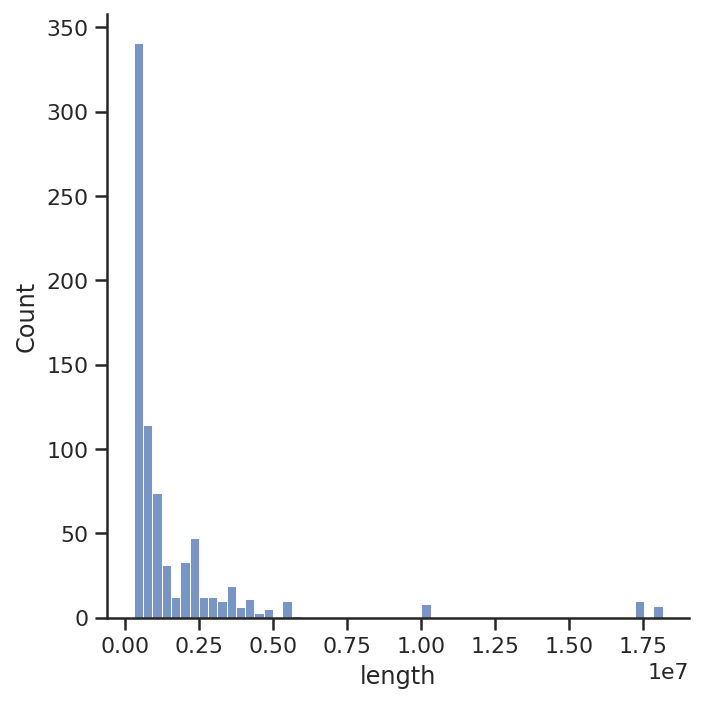

In [14]:
sns.displot(all_lowils_regions.loc[(all_lowils_regions.length > 300000) & (all_lowils_regions.mean_ils > 0.2)].length) ;

In [68]:
all_lowils_regions.loc[all_lowils_regions.trio == 'homsap_pantro_gorgor'].tail()

,start,end,sp1,sp2,sp3,sp4,chrom,mean_ils,length,trio
0,84000,86000,HOMSAP,PANTRO,GORGOR,PONABE,6,0.327831,2000,homsap_pantro_gorgor
1,89000,91000,HOMSAP,PANTRO,GORGOR,PONABE,6,0.327831,2000,homsap_pantro_gorgor
2,94000,95000,HOMSAP,PANTRO,GORGOR,PONABE,6,0.327831,1000,homsap_pantro_gorgor
3,122000,123000,HOMSAP,PANTRO,GORGOR,PONABE,6,0.327831,1000,homsap_pantro_gorgor
4,129000,132000,HOMSAP,PANTRO,GORGOR,PONABE,6,0.327831,3000,homsap_pantro_gorgor
...,...,...,...,...,...,...,...,...,...,...
13812,133677000,133679000,HOMSAP,PANTRO,GORGOR,PONABE,10,0.335272,2000,homsap_pantro_gorgor
13813,133753000,133756000,HOMSAP,PANTRO,GORGOR,PONABE,10,0.335272,3000,homsap_pantro_gorgor
13814,133757000,133759000,HOMSAP,PANTRO,GORGOR,PONABE,10,0.335272,2000,homsap_pantro_gorgor
13815,133768000,133773000,HOMSAP,PANTRO,GORGOR,PONABE,10,0.335272,5000,homsap_pantro_gorgor


In [67]:
from chromwindow import window

@window(size=100000)
def species_count(df):
    return df.index.size
     
species_count_windows = (all_lowils_regions
                         # .loc[(all_lowils_regions.length > 300000) & (all_lowils_regions.mean_ils > 0.2)]
                         .loc[all_lowils_regions.trio == 'homsap_pantro_gorgor']
                         .groupby('chrom')
                         .apply(species_count)
#                         .reset_index('chrom')
                        )
species_count_windows.to_hdf('results/species_count_windows.h5', 'df', format='table')

Exception ignored in: <function WeakSet.__init__.<locals>._remove at 0x2aef19648158>
Traceback (most recent call last):
  File "/home/kmt/anaconda3/envs/ilsvoid/lib/python3.6/_weakrefset.py", line 38, in _remove
    def _remove(item, selfref=ref(self)):
KeyboardInterrupt


KeyboardInterrupt: 

In [60]:
species_count_windows = pd.read_hdf('results/species_count_windows.h5')
species_count_windows.head()

,chrom,start,end,species_count
0,1,0,100000,5
1,1,100000,200000,10
2,1,200000,300000,6
3,1,300000,400000,1
4,1,400000,500000,10


In [61]:
species_count_windows.loc[species_count_windows.chrom == '3']

,chrom,start,end,species_count
0,3,0,100000,10
1,3,100000,200000,12
2,3,200000,300000,14
3,3,300000,400000,14
4,3,400000,500000,12
...,...,...,...,...
1978,3,197800000,197900000,18
1979,3,197900000,198000000,7
1980,3,198000000,198100000,17
1981,3,198100000,198200000,9


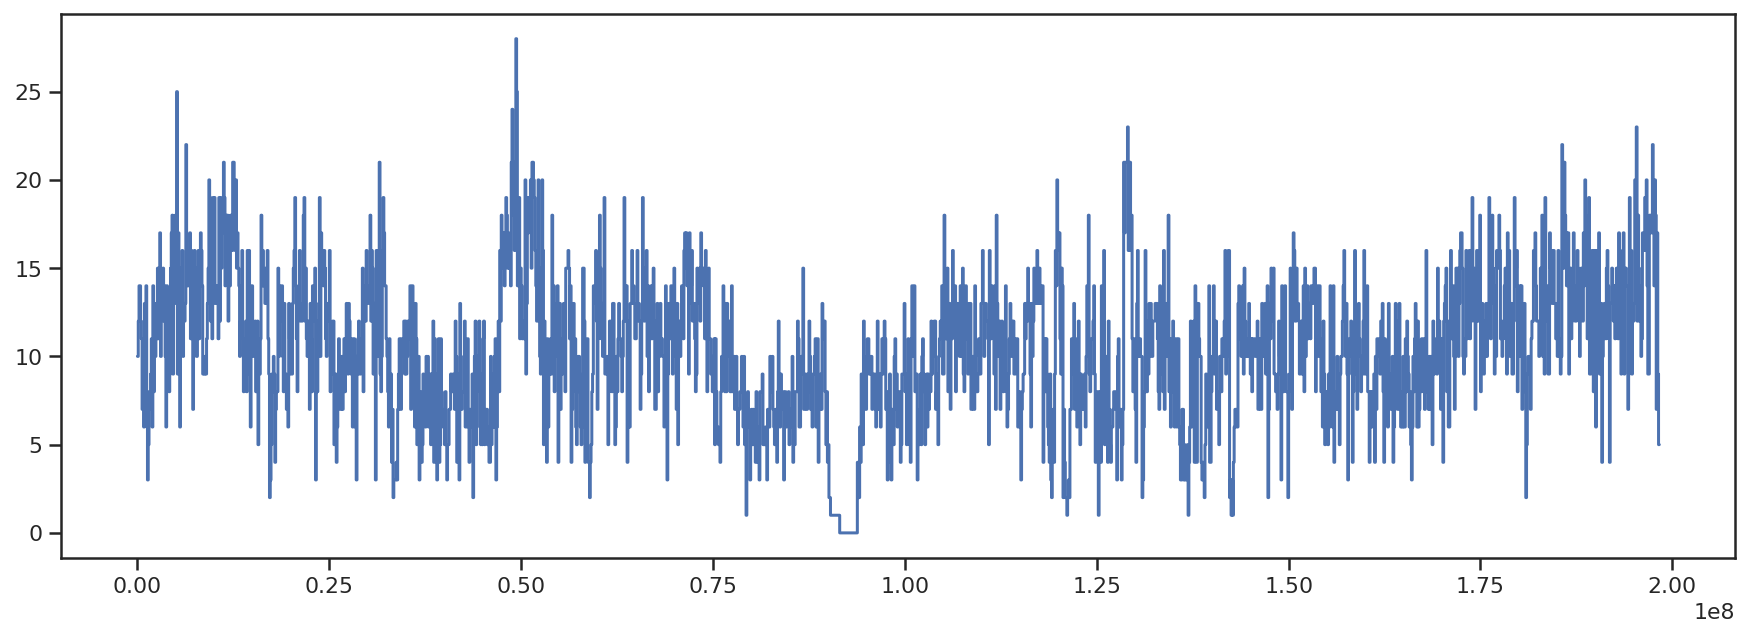

In [62]:
plt.figure(figsize=(15,5))
plot_df = stairs(species_count_windows.loc[species_count_windows.chrom == '3'])
plt.plot(plot_df.pos, plot_df.species_count)
#plt.ylim(0, 40)